### Single run of abyss

In [1]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R3/step2_params'

### Import the truth: data

This will involve reading in sediment depth measurements and potentially other morphologic parameters. This should ultimately be called, in Benoit's framework, ds_out_true

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import xsimlab as xs

### Define the xsimlab model


In [2]:
@xs.process
class UniformGrid1D:
    """Create 1D model grid with uniform spacing"""
    
    #grid parameters
    spacing = xs.variable(description="grid_spacing", static=True)
    length = xs.variable(description="grid total length", static=True)
    
    #x is an index variable, used for accessing the grid.
    x = xs.index(dims="x")
    
    #create the grid
    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [3]:
@xs.process
class ProfileZ:
    """Compute the evolution of the elevation (z) profile"""
    
    h_vars = xs.group("h_vars") #allows for multiple processes influencing; say diffusion and subsidence
    #br_vars = xs.group("br_vars") #allows for multiple processes influencing; say diffusion and subsidence

    z = xs.variable(
        dims="x", intent="inout", description="surface elevation z", attrs={"units": "m"}
    )
    #br = xs.variable(
    #    dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    #)
    br = xs.variable(
        dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    )
    h = xs.variable(
        dims="x", intent="inout", description="sed_thickness", attrs={"units": "m"}
    )
    
    dh_compact = xs.variable(
        dims="x", intent="inout", description="dh_compact", attrs={"units": "m/yr"}
    )

    def run_step(self):
        #self._delta_br = sum((br for br in self.br_vars))
        self._delta_h = sum((h for h in self.h_vars))

    def finalize_step(self):
        #self.br += self._delta_br #update bedrock surface
        self.h += self._delta_h #update sediment thickness
        self.z = self.br + self.h #add sediment to bedrock to get topo elev.

In [4]:
@xs.process
class ErosionDeposition:
    """Here's where the actual computation happens: nonlocal diffusion

    """
    
    #get input parameters
    basin_width = xs.variable(description="basin width")
    sea_level = xs.variable(description="sea level")
    k_factor = xs.variable(description="k factor")
    k_depth_scale = xs.variable(description="k depth scale")
    travel_dist = xs.variable(description="marine_travel_distance")
    s_crit = xs.variable(description="marine_critical_slope")
    sed_porosity = xs.variable(description="marine_sediment_porosity")
    sed_porosity_depth_scale = xs.variable(description="marine_sediment_porosity_depth_scale")
    qs_in = xs.variable(description="sediment_flux_in")
    
    slope = xs.variable(
        dims="x", intent="out", description="topographic_slope", attrs={"units": "-"}
    )
    depth = xs.variable(
        dims="x", intent="out", description="depth", attrs={"units": "m"}
    )
    erosion = xs.variable(
        dims="x", intent="out", description="erosion", attrs={"units": "m/yr"}
    )
    deposition = xs.variable(
        dims="x", intent="out", description="deposition", attrs={"units": "m/yr"}
    )
    dh_dt = xs.variable(
        dims="x", intent="out", description="dh_dt", attrs={"units": "m/yr"}
    )
    qs = xs.variable(
        dims="x", intent="out", description="qs", attrs={"units": "m2/yr"}
    )
    #dbr = xs.variable(dims="x", intent="out", groups="br_vars")
    dh = xs.variable(dims="x", intent="out", groups="h_vars")
    
    spacing = xs.foreign(UniformGrid1D, "spacing")
    #x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z")
    br = xs.foreign(ProfileZ, "br")
    h = xs.foreign(ProfileZ, "h")
    dh_compact = xs.foreign(ProfileZ, "dh_compact")
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        k_factor_real = np.power(10, self.k_factor)
        self.erosion = np.repeat(0., len(self.z))
        self.deposition = np.repeat(0., len(self.z))
        self.dh_dt = np.repeat(0., len(self.z))
        self.qs = np.repeat(0., len(self.z))
        self.dh = np.repeat(0., len(self.z))
        
        #divide Qs_in by basin width to get qs_in
        qs_in = self.qs_in / self.basin_width
        
        #calculate topographic slope
        self.slope = np.append(np.diff(self.z) / self.spacing, 0)
        #calculate depth below water
        self.depth = np.maximum(self.sea_level - self.z, 0)
        
        #calculate k array
        k_arr = k_factor_real * np.exp(-self.depth / self.k_depth_scale)
        
        #impose hard basin floor
        k_arr[self.z <= (self.br + 0.001)] = 0
        
        #find first marine node
        marine_or_terrestrial = self.z <= self.sea_level #boolean: true is marine
        first_marine_node = np.argmax(marine_or_terrestrial) #finds the first true
        #evolve first marine node
        if self.slope[first_marine_node] <= 0: #this is the "regular," right-draining case
            self.erosion[first_marine_node] = k_arr[first_marine_node] * np.abs(self.slope[first_marine_node])
            self.deposition[first_marine_node] = (qs_in * (1 - np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist

        else:  #this is the irregular, left-draining case
            self.erosion[first_marine_node] = 0 #because slope = 0
            self.deposition[first_marine_node] = qs_in / self.spacing #(self.qs_in * (1 + np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist #because slope = 0 #self.qs_in / self.travel_dist
        #self.dh_dt[first_marine_node] = (-self.erosion[first_marine_node] + self.deposition[first_marine_node]) / (1 - self.sed_porosity)
        #self.dh[first_marine_node] = self.dh_dt[first_marine_node] * dt
        self.dh_dt[first_marine_node] = (-self.erosion[first_marine_node] + self.deposition[first_marine_node]) / (1 - self.sed_porosity)
        self.dh[first_marine_node] = self.dh_dt[first_marine_node] * dt
        self.qs[first_marine_node] = np.maximum(qs_in + (self.erosion[first_marine_node] - self.deposition[first_marine_node]) * self.spacing, 0.)
        if -self.dh[first_marine_node] > self.h[first_marine_node]:
            self.dh[first_marine_node] = -self.h[first_marine_node]
            self.qs[first_marine_node] = np.maximum(qs_in + ((-self.dh[first_marine_node] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
        
        
        #evolve remaining marine nodes
        for i in range(first_marine_node + 1, len(self.z)): #iterate over each element of x ONLY IN THE MARINE
        
            if self.slope[i] <= 0: #this is the "regular," right-draining case
                self.deposition[i] = (self.qs[i-1] * (1 - np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.travel_dist
                self.erosion[i] = k_arr[i] * np.abs(self.slope[i])
                if self.z[i] > self.sea_level:
                    self.deposition[i] = 0
            else: #this is the irregular, left-draining case
                self.deposition[i] = self.qs[i-1] / self.spacing#(self.qs[i-1] * (1 + np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.spacing#self.travel_dist #self.qs[i-1] / self.spacing
                self.erosion[i] = 0
                if self.z[i] > self.sea_level:
                    self.deposition[i] = 0
            
            self.dh_dt[i] = (-self.erosion[i] + self.deposition[i]) / (1 - self.sed_porosity)
            
            self.dh[i] = self.dh_dt[i] * dt
            
            self.qs[i] = np.maximum(self.qs[i-1] + (self.erosion[i] - self.deposition[i]) * self.spacing, 0.)
            
            if -self.dh[i] > self.h[i]:
                self.dh[i] = -self.h[i]
                self.qs[i] = np.maximum(self.qs[i-1] + ((-self.dh[i] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
            
        #calculate change in sed thickness
        #self.dh[:first_marine_node] = 0
        #self.dh[first_marine_node:] = self.dh_dt[first_marine_node:] * dt
        #self.dh[self.erosion > self.h] = -self.h[self.erosion > self.h] #if erosion is greater than h, topo only loses h    
        
        #compact sediment
        #calculate the thickness after compaction, z0; dh is the thickness of new deposited solid sediment
        self.dh_compact[:] = self.dh[:] * (1 - self.sed_porosity)
    
        
        #compaction routine
        #def compaction(porosity, porosity_depth_scale, nn, dh, zi):
        nn = len(self.z)
        z0 = np.zeros(nn)
        #set initial guess for z0:
        z0[:] = self.h[:]

        #Newton-Raphson iteration  at every node
        for k in range(nn):
            fx = 1 #throwaway initial value to trigger "while" loop
            dfx = 1 #throwaway initial value to trigger "while" loop
            #check whether we're at the root
            if self.dh_compact[k] > 0 : #only apply compaction where deposition is happening
                while np.abs(fx / dfx) > 1e-6:
                    #calculate value of function at initial guess
                    fx = z0[k] - self.h[k] + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - self.dh_compact[k]
        
                    #calculate derivative
                    dfx = 1 - self.sed_porosity * np.exp(-z0[k] / self.sed_porosity_depth_scale)
                    z0[k] = z0[k] - fx / dfx

            elif self.dh_compact[k] == 0: #no e or d
                z0[k] = self.h[k]
            else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
                z0[k] = self.h[k] + self.dh_compact[k] / (1 - self.sed_porosity)
        
        #here, have a chance to set the final dh by differencing new h (z0) and old h (h)
        self.dh[:] = z0[:] - self.h[:]
        
        #finalize changes to bedrock (subsidence) and sediment thickness (e/d)
        #self.dbr = (self.subsidence * dt)

In [5]:
@xs.process
class InitBasinGeom:
    """
    Give initial basin elevation field as a function of x:
    z = exp(- (x - a) / b) + c
    """
    
    #a = xs.variable(description="shift parameter", static=True)
    #b = xs.variable(description="scale parameter", static=True)
    #c = xs.variable(description="initial basin floor altitude", static=True)
    #d = xs.variable(description="x multiplier", static=True)

    init_br = xs.variable(dims="x", description="shift parameter", static=True)
    
    x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z", intent="out")
    #br = xs.foreign(ProfileZ, "br", intent="in")
    h = xs.foreign(ProfileZ, "h", intent="out")
    dh_compact = xs.foreign(ProfileZ, "dh_compact", intent="out")
    def initialize(self):
        #self.br = np.exp(- (self.x * self.d - self.a) / self.b) + self.c #build the initial topography
        self.h = np.zeros(len(self.x)) #initial sediment thickness is 0
        self.z = np.zeros(len(self.x)) + self.init_br #self.br#(np.exp(- (self.x * self.d - self.a) / self.b) + self.c) + self.h
        self.dh_compact = np.zeros(len(self.x))

In [6]:
marine = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileZ,
        "init": InitBasinGeom,
        "erode": ErosionDeposition,
    }
)

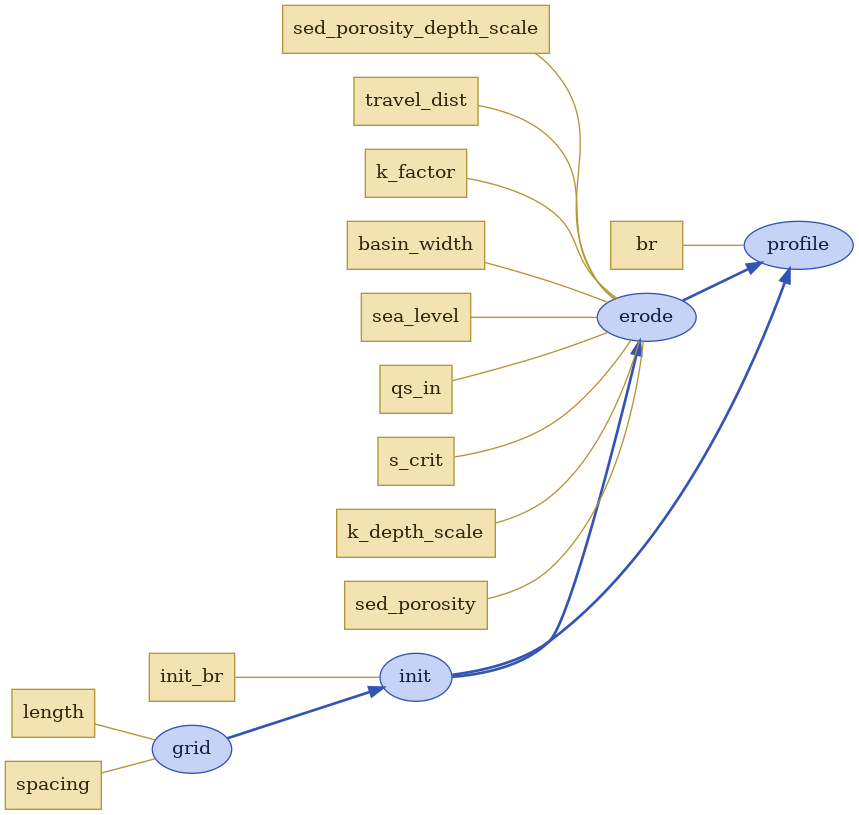

In [7]:
marine.visualize(show_inputs=True)

In [8]:
#need to import basement elevation and qs time series after they were exported by the prepro notebook
bedrock_file = '../prepro/bedrock_elev_array.npy'
br = np.load(bedrock_file)
bedrock_elev_array = xr.DataArray(br, dims=['time', 'x'])
initial_bedrock = bedrock_elev_array[0, :]

qs_file = '../prepro/qs_array.npy'
qs_array = np.load(qs_file)
qs_array = xr.DataArray(qs_array, dims=['time'])
#this is loading in the full m3/yr numbers directly from Baby et al 2019.

#so need to divide by the basin width before piping it into the model.
#import best-fit basin width from pyABC inference
#basin_width_file = '../step1_qs_in/best_fit_basin_width.npy'
#basin_width = 1.#np.load(basin_width_file)[0] #first and only element of array
#qs_array = qs_array[:] / basin_width #now we're in the right units for the model

In [9]:
basin_width

1.0

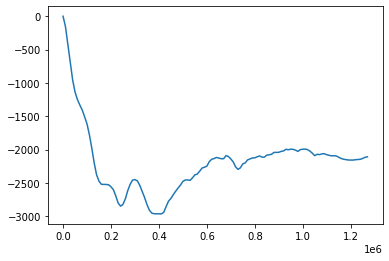

In [10]:
x = np.arange(0, 1280000, 10000)
plt.plot(x,bedrock_elev_array[0, :])

In [11]:
#read in best fit params:
best_fit_params = np.load('best_fit_params.npy')
travel_distance = best_fit_params[0]
k_factor = best_fit_params[1]
k_depth_scale = best_fit_params[2]
critical_slope = best_fit_params[3]

In [12]:
k_factor

0.5802016607568726

In [13]:
in_ds = xs.create_setup(
   ...:     model=marine,
   ...:     clocks={
   ...:         'time': np.arange(0, 130000000, 1000),
   ...:         'otime': np.append(np.arange(0, 130000000, 1000), 129999000)#np.append(np.arange(0, 130000000, 1000000), 129999000) #np.array([19999000])
   ...:     },
   ...:     master_clock='time',
   ...:     input_vars={
   ...:         'grid': {'length': 1280000., 'spacing': 10000.},
                'init': {'init_br': initial_bedrock},
                'erode': {
                    'k_factor': k_factor,
                    'k_depth_scale': k_depth_scale,
                    's_crit': critical_slope,
                    'travel_dist': travel_distance,
                    'sed_porosity': 0.56,
                    'sed_porosity_depth_scale': 2830.,
                    'sea_level': 0.,
                    'qs_in': qs_array,
                    'basin_width': 1.0
                },
                'profile': {
                    'br': bedrock_elev_array
                },
   },
            output_vars={'profile__z': 'otime', 'profile__br': 'otime', 'profile__h': 'otime', 'profile__dh_compact': 'otime'}
)

### Here we import the data that will be used to calculate model misfit

In [8]:
sed_surfaces = np.load('../prepro/all_surfaces.npy')
top_surface = sed_surfaces[-1, :] #this is the top of the U8 surface
br_surface = sed_surfaces[0, :]



In [15]:
with marine: 
    out_ds = in_ds.xsimlab.run(store="best_fit_006.zarr")

5001

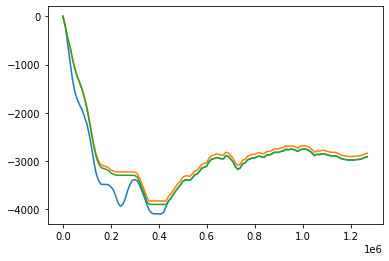

In [16]:

plt.plot(out_ds.x, out_ds.profile__br[-2, :])
plt.plot(out_ds.x, out_ds.profile__z[-500, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :])

len(np.array(out_ds.profile__z))

In [16]:
#integrate sedflux
qs_integral = np.sum(np.array(qs_array) * 1000)
phi = 0.56
z_star = 2830.
n_nodes=128
#now integrate deposit given known porosity and decay depth
#check if integral of modern modeled sed agrees with either of the qs curves
tot_depth_top = np.zeros(n_nodes)
tot_depth_bottom = np.array(out_ds.profile__z[-2, :] - out_ds.profile__br[-2, :])
solid_thickness = phi * z_star * np.exp(-tot_depth_bottom/z_star) * (np.exp((tot_depth_top-tot_depth_bottom)/z_star) - 1) - (tot_depth_top-tot_depth_bottom)
total_integral_model = np.sum(solid_thickness) * 10000

print('modeled: ' + str(total_integral_model) )
np.save('phi_0.npy', np.array(out_ds.profile__z[-2, :]))
print('qs: ' + str(qs_integral) )

modeled: 3000629407.550325
qs: 2376798914.3601193


In [17]:
#test indefinite integral solved at both bounds:
#indefinite integral is phi * z_* * exp(-z/z_*) + z

integral_at_upper_depth = phi * z_star * np.exp(-tot_depth_top/z_star) + tot_depth_top
integral_at_lower_depth = phi * z_star * np.exp(-tot_depth_bottom/z_star) + tot_depth_bottom

def_int = - (integral_at_upper_depth - integral_at_lower_depth) #negative because reversing bounds of integration
tot_def_int = np.sum(def_int) * 10000
print('modeled but revised integral calc: ' + str(tot_def_int))

modeled but revised integral calc: 2362410469.986945


In [19]:
#brute force integral
test = np.sum(np.array(out_ds.profile__z[-2, :] - out_ds.profile__br[-2, :]))*10000 * (1 - phi) #estimate of solid sed in domain
print(test)

test2 = np.sum(np.array(qs_array[0:5000]) * 1000) 
print(test2)

52666913.297362834
56870383.72589424


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]

In [18]:
elevs = np.array(out_ds.profile__z[-2, :])
np.diff(elevs) / 10000

array([-7.13835883e-02, -2.45087365e-02, -1.76475886e-02, -2.45513833e-02,
       -2.10028243e-02, -1.57665569e-02, -1.33492400e-02, -1.40258557e-02,
       -1.75824407e-02, -2.13316420e-02, -2.66391686e-02, -2.83873016e-02,
       -2.65991538e-02, -2.07772074e-02, -1.29176362e-02, -7.42905331e-03,
       -1.70051772e-03, -1.72943674e-03, -2.36878141e-03, -5.28770419e-03,
       -1.92638285e-03, -2.44437399e-03, -2.94775636e-05, -9.31350424e-05,
       -3.96071347e-05, -6.95482181e-05, -5.91259613e-05, -3.48648334e-05,
       -2.86652541e-05, -3.36214248e-04, -3.18506397e-03, -9.77943843e-03,
       -1.27976995e-02, -1.31189390e-02, -1.45493872e-02, -6.44701843e-03,
       -3.26018126e-05, -4.69462164e-05, -4.35414933e-05, -2.12188890e-05,
        1.91549183e-05, -2.69973913e-05, -1.71190341e-05,  6.70924161e-03,
        5.74697491e-03,  7.77715488e-03,  7.25067216e-03,  6.66371591e-03,
        6.05955008e-03,  7.46527305e-03,  3.07206649e-03,  9.44706888e-05,
       -9.31720936e-04,  

In [18]:
#calc misfit
obs_h = sed_surfaces[-1, :] - sed_surfaces[0, :]
misfit = np.sqrt((1/73) * np.sum(np.power(obs_h[1:] - out_ds.profile__h[-1, 1:], 2)/np.power(10,2)))
print(np.float(misfit))

0.0


(0.0, 1400000.0)

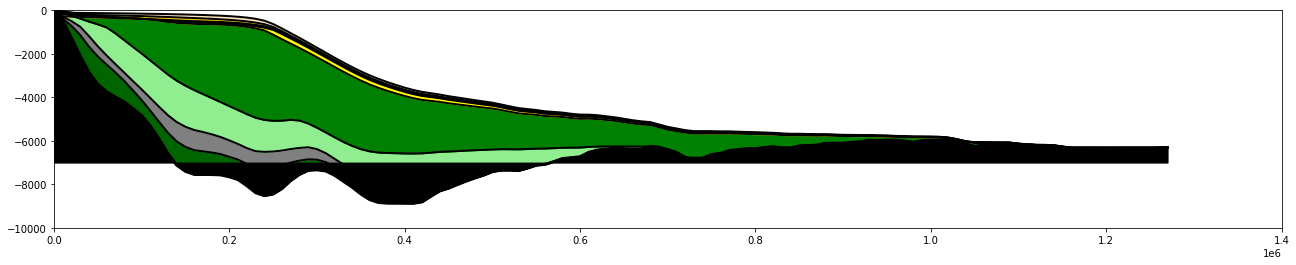

In [18]:
batch_flag=0
if batch_flag == 1:
    for i in range(n_runs):

        #plot stratigraphy adjusted for later subsidence
        plt.figure(figsize=(22,2))
        final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[i,-2, :], linewidth = 3, color = 'k')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
        br_diff0000 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,129, :]
        br_diff000 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,119, :]
        br_diff00 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,100, :]
        br_diff0 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,64, :]
        br_diff1 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,49, :]
        br_diff2 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,36, :]
        br_diff3 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,30, :]
        br_diff4 = out_ds.profile__br[i,-1, :] - out_ds.profile__br[i,17, :]
        plt.plot(out_ds.x, out_ds.profile__z[i,129, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,119, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,100, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,64, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,49, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,36, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,30, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
        plt.plot(out_ds.x, out_ds.profile__z[i,17, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

        #fill in all the strata
        plt.fill_between(out_ds.x, out_ds.profile__br[i,-1, :], out_ds.profile__z[i,17, :] + br_diff4, color = 'darkgreen')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,17, :] + br_diff4, out_ds.profile__z[i,30, :] + br_diff3, color = 'gray')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,30, :] + br_diff3, out_ds.profile__z[i,36, :] + br_diff2, color = 'lightgreen')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,36, :] + br_diff2, out_ds.profile__z[i,49, :] + br_diff1, color = 'green')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,49, :] + br_diff1, out_ds.profile__z[i,64, :] + br_diff0, color = 'yellow')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,64, :] + br_diff0, out_ds.profile__z[i,100, :] + br_diff00, color = 'orange')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,100, :] + br_diff00, out_ds.profile__z[i,119, :] + br_diff000, color = 'gold')
        plt.fill_between(out_ds.x, out_ds.profile__z[i,119, :] + br_diff000, out_ds.profile__z[i,129, :] + br_diff0000, color = 'bisque')
        plt.fill_between(out_ds.x, -7000, out_ds.profile__br[i,-1, :], color = 'k')

else: #not batched
    #plot stratigraphy adjusted for later subsidence
    plt.figure(figsize=(22,4))
    final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[-2, :], linewidth = 3, color = 'k')
    #plt.plot(out_ds.x, out_ds.profile__z[-1, :], linewidth = 3, color = 'k', linestyle='--')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
    br_diff0000 = out_ds.profile__br[-2, :] - out_ds.profile__br[129000, :]


    br_diff000 = out_ds.profile__br[-2, :] - out_ds.profile__br[119000, :]


    br_diff00 = out_ds.profile__br[-2, :] - out_ds.profile__br[100000, :]


    br_diff0 = out_ds.profile__br[-2, :] - out_ds.profile__br[64000, :]


    br_diff1 = out_ds.profile__br[-2, :] - out_ds.profile__br[49000, :]
    br_diff2 = out_ds.profile__br[-2, :] - out_ds.profile__br[36000, :]

    br_diff3 = out_ds.profile__br[-2, :] - out_ds.profile__br[30000, :]


    br_diff4 = out_ds.profile__br[-2, :] - out_ds.profile__br[17000, :]
    plt.plot(out_ds.x, out_ds.profile__z[129000, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')

    plt.plot(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
    plt.plot(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

    #fill in all the strata
    plt.fill_between(out_ds.x, out_ds.profile__br[-2, :], out_ds.profile__z[17000, :] + br_diff4, color = 'darkgreen')
    plt.fill_between(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, out_ds.profile__z[30000, :] + br_diff3, color = 'gray')
    plt.fill_between(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, out_ds.profile__z[36000, :] + br_diff2, color = 'lightgreen')
    plt.fill_between(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, out_ds.profile__z[49000, :] + br_diff1, color = 'green')
    plt.fill_between(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, out_ds.profile__z[64000, :] + br_diff0, color = 'yellow')
    plt.fill_between(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, out_ds.profile__z[100000, :] + br_diff00, color = 'orange')
    plt.fill_between(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, out_ds.profile__z[119000, :] + br_diff000, color = 'gold')
    plt.fill_between(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, out_ds.profile__z[129000, :] + br_diff0000, color = 'bisque')
    plt.fill_between(out_ds.x, -7000, out_ds.profile__br[-2, :], color = 'k')
    #plt.scatter(150000, sed_surfaces[8, 15], color = 'r')
    #plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
    #plt.scatter(200000, sed_surfaces[8, 20], color = 'r')

    #plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
    #plt.scatter(600000, sed_surfaces[8, 60], color = 'r', zorder = 5)
    #plt.scatter(900000, sed_surfaces[8, 90], color = 'r')
    #plt.plot(out_ds.x, out_ds.profile__z[-110, :], linewidth = 3, color = 'g', linestyle=':')

plt.ylim(-10000, 0)
plt.xlim(0, 1400000)

#plt.ylim(-1000, 0)
#plt.xlim(0, 100000)

(0.0, 1400000.0)

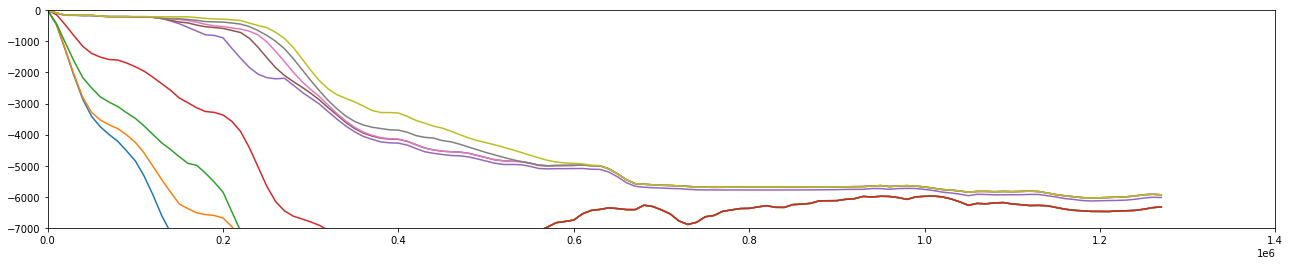

In [19]:
sed_surfaces = np.load('../prepro/all_surfaces.npy')
top_surface = sed_surfaces[-1, :] #this is the top of the U8 surface
br_surface = sed_surfaces[0, :]
plt.figure(figsize=(22,4))
plt.plot(out_ds.x, sed_surfaces[0, :])
plt.plot(out_ds.x, sed_surfaces[1, :])
plt.plot(out_ds.x, sed_surfaces[2, :])
plt.plot(out_ds.x, sed_surfaces[3, :])
plt.plot(out_ds.x, sed_surfaces[4, :])
plt.plot(out_ds.x, sed_surfaces[5, :])
plt.plot(out_ds.x, sed_surfaces[6, :])
plt.plot(out_ds.x, sed_surfaces[7, :])
plt.plot(out_ds.x, sed_surfaces[8, :])
#plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
#plt.scatter(200000, sed_surfaces[8, 20], color = 'r')
#plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
#plt.scatter(600000, sed_surfaces[8, 60], color = 'r')
#plt.scatter(1100000, sed_surfaces[8, 110], color = 'r')
plt.ylim(-7000, 0)
plt.xlim(0, 1400000)
#plt.ylim(-2000, 0)
#plt.xlim(0, 200000)

In [20]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R3/step2_params'

nan


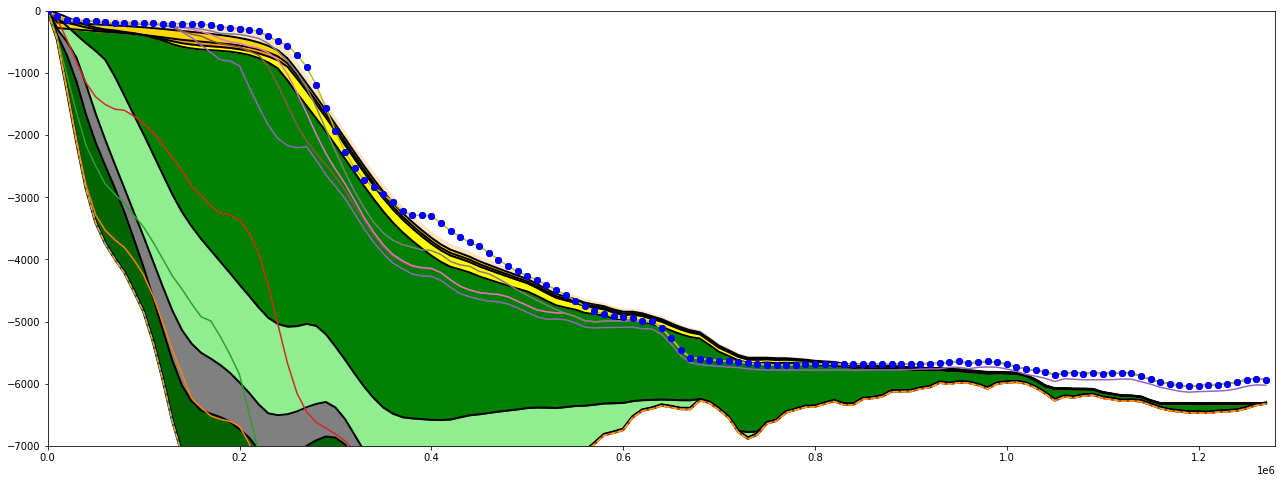

In [21]:
plt.figure(figsize=(22,8))
final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[-2, :], linewidth = 3, color = 'k')
    #plt.plot(out_ds.x, out_ds.profile__z[-1, :], linewidth = 3, color = 'k', linestyle='--')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
br_diff0000 = out_ds.profile__br[-2, :] - out_ds.profile__br[129000, :]
br_diff000 = out_ds.profile__br[-2, :] - out_ds.profile__br[119000, :]
br_diff00 = out_ds.profile__br[-2, :] - out_ds.profile__br[100000, :]
br_diff0 = out_ds.profile__br[-2, :] - out_ds.profile__br[64000, :]
br_diff1 = out_ds.profile__br[-2, :] - out_ds.profile__br[49000, :]
br_diff2 = out_ds.profile__br[-2, :] - out_ds.profile__br[36000, :]
br_diff3 = out_ds.profile__br[-2, :] - out_ds.profile__br[30000, :]


br_diff4 = out_ds.profile__br[-2, :] - out_ds.profile__br[17000, :]
plt.plot(out_ds.x, out_ds.profile__z[130000, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

    #fill in all the strata
plt.fill_between(out_ds.x, out_ds.profile__br[-2, :], out_ds.profile__z[17000, :] + br_diff4, color = 'darkgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, out_ds.profile__z[30000, :] + br_diff3, color = 'gray')
plt.fill_between(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, out_ds.profile__z[36000, :] + br_diff2, color = 'lightgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, out_ds.profile__z[49000, :] + br_diff1, color = 'green')
plt.fill_between(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, out_ds.profile__z[64000, :] + br_diff0, color = 'yellow')
plt.fill_between(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, out_ds.profile__z[100000, :] + br_diff00, color = 'orange')
plt.fill_between(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, out_ds.profile__z[119000, :] + br_diff000, color = 'gold')
plt.fill_between(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, out_ds.profile__z[129000, :] + br_diff0000, color = 'bisque')
plt.fill_between(out_ds.x, -7000, out_ds.profile__br[-1, :], color = 'k')
    #plt.scatter(150000, sed_surfaces[8, 15], color = 'r')
plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
plt.scatter(200000, sed_surfaces[8, 20], color = 'r')

plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
plt.scatter(600000, sed_surfaces[8, 60], color = 'r')
#plt.scatter(1100000, sed_surfaces[8, 110], color = 'r')
 #plt.plot(out_ds.x, out_ds.profile__z[-110, :], linewidth = 3, color = 'g', linestyle=':')
plt.plot(out_ds.x, sed_surfaces[0, :])
plt.plot(out_ds.x, sed_surfaces[1, :])
plt.plot(out_ds.x, sed_surfaces[2, :])
plt.plot(out_ds.x, sed_surfaces[3, :])
plt.plot(out_ds.x, sed_surfaces[4, :])
plt.plot(out_ds.x, sed_surfaces[5, :])
plt.plot(out_ds.x, sed_surfaces[6, :])
plt.plot(out_ds.x, sed_surfaces[7, :])
plt.plot(out_ds.x, sed_surfaces[8, :])
#plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
#plt.scatter(200000, sed_surfaces[8, 20], color = 'r')
#plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
#plt.scatter(600000, sed_surfaces[8, 60], color = 'r', zorder = 5)
#plt.scatter(900000, sed_surfaces[8, 90], color = 'r')
plt.scatter(out_ds.x, sed_surfaces[8, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-1, :], color = 'g', zorder = 5)

plt.ylim(-7000, 0)
plt.xlim(0, 1280000)
#plt.ylim(-7000, 0)
#plt.xlim(0, 1400000)
#model final bedrock
plt.plot(out_ds.x, out_ds.profile__br[-1, :], color = 'r', linestyle='-.')
#data final bedrock
plt.plot(out_ds.x, sed_surfaces[0, :], color = 'orange', linestyle='--')
plt.scatter(out_ds.x, sed_surfaces[-1, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-1, :], color = 'g', zorder = 5)
print(np.array(out_ds.profile__z[-1, 6]))

In [21]:
#now need to try to deform the modeled layers to account for deposition above them
#for the moment just try one at a time

#start with the bottom layer (top of U1)
#procedure here is to:
#1) write a function that compacts the layer and iterively tracks the elevation of its top
#2) the input to this function is dh_solid, the solid sed volume deposited above at each timestep
#we call this function at every point, once every timestep since layer was finished depositing.
out_ds = xr.open_zarr('test_strat_compaction_qs_integral.zarr')
#so, first layer is at 17000000 years
n_nodes = 74
first_layer = np.array(out_ds.profile__z[17000, :])
h = 0#np.zeros(n_nodes) #array n_nodes long holding the accumulated solid thickness ABOVE the given layer. starts at 0.
z0 = 0#np.zeros(n_nodes)
#initial guess for z0, which is the depth of the layer marker below the current bathymetric surface
dh_compact = 1.#np.ones(n_nodes)#np.array(out_ds.profile__dh_compact)
porosity = 0.5 #0.56
z_star = 2500.#2830.
save_solid_thickness = np.zeros((5000, n_nodes))
save_sed_thickness = np.zeros((5000, n_nodes))
for timestep in range(5000):
    #print(timestep)
    h += dh_compact
    #print(h)
    save_solid_thickness[timestep, :] = h
    #print(dh_compact)
    z0 = h
    #print(z0)
    for k in range(n_nodes):
        #print(k)
        fx = 1 #throwaway initial value to trigger "while" loop
        dfx = 1 #throwaway initial value to trigger "while" loop
        #check whether we're at the root
        #if self.dh_compact[k] > 0 : #only apply compaction where deposition is happening
        while np.abs(fx / dfx) > 1e-6:
            #print(str(z0[k]) + ' z0')
            #print('node' + str(k))
            #print(np.abs(fx / dfx))
            #calculate value of function at initial guess
            fx = z0 + porosity * z_star * np.exp(-z0/z_star) - porosity * z_star - h# + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - self.dh_compact[k]
        
            #calculate derivative
            dfx = 1 - porosity * np.exp(-z0 / z_star)
            z0 = z0 - fx / dfx
            #print(z0)
        save_sed_thickness[timestep, k] = z0
        #elif self.dh_compact[k] == 0: #no e or d
        #    z0[k] = self.h[k]
        #else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
        #    z0[k] = self.h[k] + self.dh_compact[k] / (1 - self.sed_porosity)


In [22]:
fx

0.0

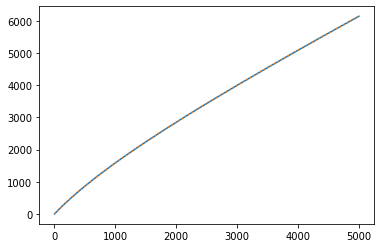

In [23]:
plt.plot(save_solid_thickness[:, 0], save_sed_thickness[:, 0])
plt.plot(save_solid_thickness[:, -1], save_sed_thickness[:, -1], linestyle=':')

In [24]:
h = np.zeros(n_nodes) #array n_nodes long holding the accumulated solid thickness ABOVE the given layer. starts at 0.
z0 = np.zeros(n_nodes)
#initial guess for z0, which is the depth of the layer marker below the current bathymetric surface
dh_compact = np.ones(n_nodes)#np.array(out_ds.profile__dh_compact)
dh_compact[-1] = 1.1
porosity = 0.5 #0.56
z_star = 2500.#2830.
save_solid_thickness = np.zeros((5000, n_nodes))
save_sed_thickness = np.zeros((5000, n_nodes))
for timestep in range(5000):
    #print(timestep)
    h[:] += dh_compact[:]
    #print(h)
    save_solid_thickness[timestep, :] = h[:]
    #print(dh_compact)
    z0[:] = h[:]
    #print(z0)
    for k in range(n_nodes):
        #print(k)
        fx = 1 #throwaway initial value to trigger "while" loop
        dfx = 1 #throwaway initial value to trigger "while" loop
        #check whether we're at the root
        #if self.dh_compact[k] > 0 : #only apply compaction where deposition is happening
        while np.abs(fx / dfx) > 1e-6:
            #print(str(z0[k]) + ' z0')
            #print('node' + str(k))
            #print(np.abs(fx / dfx))
            #calculate value of function at initial guess
            fx = z0[k] + porosity * z_star * np.exp(-z0[k]/z_star) - porosity * z_star - h[k]# + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - self.dh_compact[k]
        
            #calculate derivative
            dfx = 1 - porosity * np.exp(-z0[k] / z_star)
            z0[k] = z0[k] - fx / dfx
            #print(z0)
        save_sed_thickness[timestep, k] = z0[k]
        #elif self.dh_compact[k] == 0: #no e or d
        #    z0[k] = self.h[k]
        #else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
        #    z0[k] = self.h[k] + self.dh_compact[k] / (1 - self.sed_porosity)


Text(0.5, 1.0, 'array version')

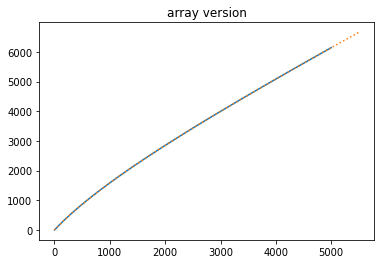

In [25]:
plt.plot(save_solid_thickness[:, 0], save_sed_thickness[:, 0])
plt.plot(save_solid_thickness[:, -1], save_sed_thickness[:, -1], linestyle=':')
plt.title('array version')

Text(0.5, 1.0, 'array version')

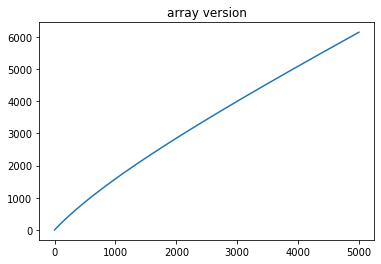

In [26]:
plt.plot(np.arange(5000), save_sed_thickness[:, 0])
#plt.plot(save_solid_thickness[:, -1], save_sed_thickness[:, -1], linestyle=':')
plt.title('array version')

In [27]:
compact[17000, :]

NameError: name 'compact' is not defined

In [ ]:
len(compact[0, :])

In [ ]:
np.array(out_ds.profile__h[17000, :])

### Below is the first shot at actually doing this for top of U1

In [ ]:
h = np.zeros(n_nodes)#np.array(out_ds.profile__h[119000, :]) #array n_nodes long holding the accumulated solid thickness ABOVE the given layer. starts at 0.
z0 = np.zeros(n_nodes)
#initial guess for z0, which is the depth of the layer marker below the current bathymetric surface
dh_compact = np.ones(n_nodes)#np.array(out_ds.profile__dh_compact)
#dh_compact[-1] = 1.1
porosity = 0.56
z_star = 2830.
save_solid_thickness = np.zeros((11000, n_nodes))
save_sed_thickness = np.zeros((11000, n_nodes))
timestep_iter = 0
for timestep in range(119000, 130000):
    if timestep%1000==0:
        print(timestep)
    dh_compact = np.array(out_ds.profile__dh_compact[timestep, :])
    #print(timestep)
    h[:] += dh_compact[:]
    #print(h)
    save_solid_thickness[timestep_iter, :] = h[:]
    #print(dh_compact)
    z0[:] = h[:]
    #print(z0)
    for k in range(n_nodes):
        #print(k)
        fx = 1 #throwaway initial value to trigger "while" loop
        dfx = 1 #throwaway initial value to trigger "while" loop
        #check whether we're at the root
        #if self.dh_compact[k] > 0 : #only apply compaction where deposition is happening
        while np.abs(fx / dfx) > 1e-6:
            #print(str(z0[k]) + ' z0')
            #print('node' + str(k))
            #print(np.abs(fx / dfx))
            #calculate value of function at initial guess
            fx = z0[k] + porosity * z_star * np.exp(-z0[k]/z_star) - porosity * z_star - h[k]# + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - self.dh_compact[k]
        
            #calculate derivative
            dfx = 1 - porosity * np.exp(-z0[k] / z_star)
            z0[k] = z0[k] - fx / dfx
            #print(z0)
        save_sed_thickness[timestep_iter, k] = z0[k]
    timestep_iter += 1
        #elif self.dh_compact[k] == 0: #no e or d
        #    z0[k] = self.h[k]
        #else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
        #    z0[k] = self.h[k] + self.dh_compact[k] / (1 - self.sed_porosity)


In [ ]:
np.array(out_ds.profile__dh_compact[130000, :])

In [ ]:
plt.plot(out_ds.x, save_sed_thickness[-1, :])
plt.plot(out_ds.x, save_solid_thickness[-1, :])
#plt.plot(out_ds.x, out_ds.profile__h[-2, :])

In [ ]:
plt.plot(out_ds.x, out_ds.profile__h[129999, :] - out_ds.profile__h[119000, :])
plt.plot(out_ds.x, save_solid_thickness[-1, :])


In [ ]:
save_solid_thickness[-1, :]

In [ ]:
plt.plot(out_ds.x, out_ds.profile__z[129999, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[-1, :])

In [ ]:
range(17000, 23000)

In [2]:
out_ds = xr.open_zarr('best_fit_006.zarr')


## this is the full treatment: do the calculation for EVERY layer

In [3]:
import multiprocessing

#initial guess for z0, which is the depth of the layer marker below the current bathymetric surface
#dh_compact[-1] = 1.1
n_nodes=128
porosity = 0.56
z_star = 2830.
#save_solid_thickness = np.zeros((11000, n_nodes))
save_sed_thickness = np.zeros((7, n_nodes)) #save u1-u7 surface
layer_times = [17000, 30000, 36000, 49000, 64000, 100000, 119000]#final depo time of each layer    
#layer_iter = 0

def do_compaction(i, layer_time):
    sed_thickness = np.zeros(n_nodes)
    #layer_time = layer_times[i]
    print('layer: ' + str(layer_time) + '\n')
    h = np.zeros(n_nodes)#np.array(out_ds.profile__h[119000, :]) #array n_nodes long holding the accumulated solid thickness ABOVE the given layer. starts at 0.
    z0 = np.zeros(n_nodes)
    dh_compact = np.ones(n_nodes)#np.array(out_ds.profile__dh_compact)
    for timestep in range(layer_time, 130000):
        if timestep%1000==0:
            print(str(layer_time) + ': ' + str(timestep) + '\n')
        dh_compact = np.array(out_ds.profile__dh_compact[timestep, :])
        #print(timestep)
        h[:] += dh_compact[:]
        #print(h)
        #save_solid_thickness[layer_iter, :] = h[:]
        #print(dh_compact)
        z0[:] = h[:]
        #print(z0)
        for k in range(n_nodes):
            #print(k)
            fx = 1 #throwaway initial value to trigger "while" loop
            dfx = 1 #throwaway initial value to trigger "while" loop
            #check whether we're at the root
            #if self.dh_compact[k] > 0 : #only apply compaction where deposition is happening
            while np.abs(fx / dfx) > 1e-6:
                #print(str(z0[k]) + ' z0')
                #print('node' + str(k))
                #print(np.abs(fx / dfx))
                #calculate value of function at initial guess
                fx = z0[k] + porosity * z_star * np.exp(-z0[k]/z_star) - porosity * z_star - h[k]# + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - self.dh_compact[k]
        
                #calculate derivative
                dfx = 1 - porosity * np.exp(-z0[k] / z_star)
                z0[k] = z0[k] - fx / dfx
                #print(z0)
            sed_thickness[k] = z0[k]
    np.save('sed_thickness_006' + str(layer_time) + '.npy', sed_thickness)
    print('run ' + str(i) + 'done')

def work(i):
    layer_time = layer_times[i]
    do_compaction(i, layer_time)
    #print(str(i) + 'done')

max_n_processes = 8 #apparently 8 on my MBP
total_tasks = len(layer_times)

pool = multiprocessing.Pool(processes=max_n_processes)
tasks = range(total_tasks)
results = pool.map(work, tasks, chunksize=1) #not map_async #this is where the magic happens
pool.close()
pool.join()

layer: 30000
layer: 36000
layer: 119000
layer: 17000
layer: 64000
layer: 49000
layer: 100000







30000: 30000
36000: 36000
64000: 64000
17000: 17000
49000: 49000
100000: 100000
119000: 119000







17000: 18000

30000: 31000

49000: 50000

100000: 101000

36000: 37000

119000: 120000

64000: 65000

17000: 19000

30000: 32000

49000: 51000

100000: 102000

119000: 121000

36000: 38000

64000: 66000

17000: 20000

30000: 33000

49000: 52000

100000: 103000

119000: 122000

36000: 39000

64000: 67000

17000: 21000

30000: 34000

49000: 53000

100000: 104000

119000: 123000

36000: 40000

64000: 68000

17000: 22000

30000: 35000

49000: 54000

119000: 124000

100000: 105000

64000: 69000

36000: 41000

17000: 23000

30000: 36000

49000: 55000

119000: 125000

100000: 106000

64000: 70000

36000: 42000

17000: 24000

30000: 37000

49000: 56000

119000: 126000

100000: 107000

17000: 25000

64000: 71000

36000: 43000

30000: 38000

49000: 57000

119000: 127000

17000: 26000

100000: 1080

In [5]:
n_nodes=128
save_sed_thickness = np.zeros((7, n_nodes))
save_sed_thickness[0] = np.load('sed_thickness_00617000.npy')
save_sed_thickness[1] = np.load('sed_thickness_00630000.npy')
save_sed_thickness[2] = np.load('sed_thickness_00636000.npy')
save_sed_thickness[3] = np.load('sed_thickness_00649000.npy')
save_sed_thickness[4] = np.load('sed_thickness_00664000.npy')
save_sed_thickness[5] = np.load('sed_thickness_006100000.npy')
save_sed_thickness[6] = np.load('sed_thickness_006119000.npy')
np.save('save_sed_thickness_006.npy', save_sed_thickness)

Text(0.5, 1.0, 'layers true position from compaction code')

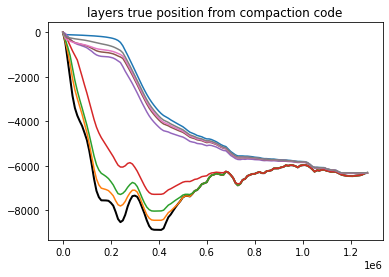

In [6]:
plt.plot(out_ds.x, out_ds.profile__br[-2, :], color = 'k', linewidth = 2)
plt.plot(out_ds.x, out_ds.profile__z[129999, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[0, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[1, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[2, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[3, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[4, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[5, :])
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[6, :])
plt.title('layers true position from compaction code')

nan


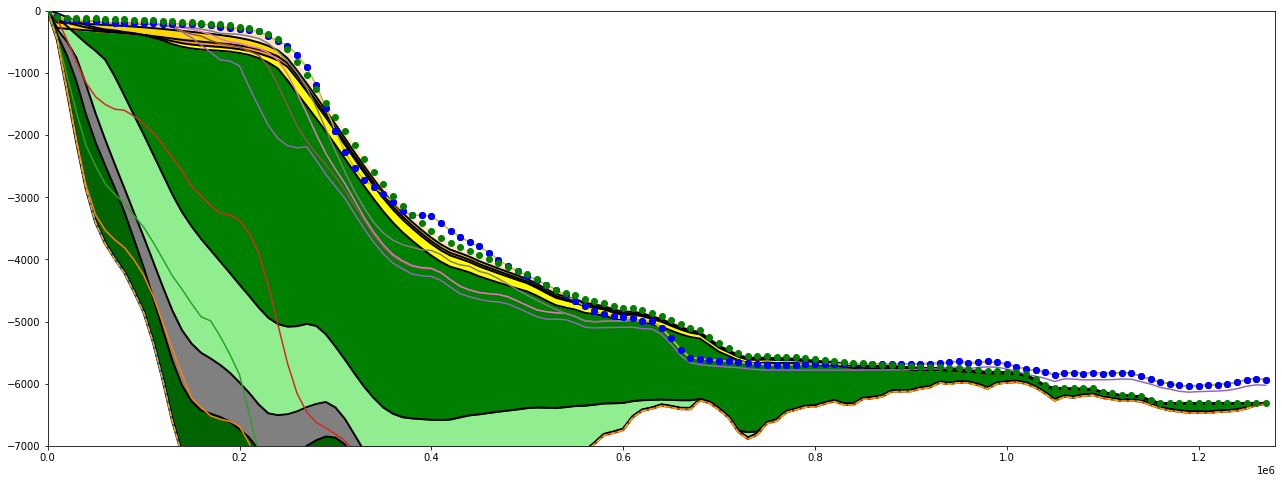

In [11]:
plt.figure(figsize=(22,8))
final_bedrock = plt.plot(out_ds.x, out_ds.profile__br[-2, :], linewidth = 3, color = 'k')
    #plt.plot(out_ds.x, out_ds.profile__z[-1, :], linewidth = 3, color = 'k', linestyle='--')

    #ex: plot adjusted topography from halfway through simulation (otime[65])
    #calc difference between bedrock at time of interest and final bedrock
br_diff0000 = out_ds.profile__br[-2, :] - out_ds.profile__br[129000, :]
br_diff000 = out_ds.profile__br[-2, :] - out_ds.profile__br[119000, :]
br_diff00 = out_ds.profile__br[-2, :] - out_ds.profile__br[100000, :]
br_diff0 = out_ds.profile__br[-2, :] - out_ds.profile__br[64000, :]
br_diff1 = out_ds.profile__br[-2, :] - out_ds.profile__br[49000, :]
br_diff2 = out_ds.profile__br[-2, :] - out_ds.profile__br[36000, :]
br_diff3 = out_ds.profile__br[-2, :] - out_ds.profile__br[30000, :]


br_diff4 = out_ds.profile__br[-2, :] - out_ds.profile__br[17000, :]
plt.plot(out_ds.x, out_ds.profile__z[130000, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, linewidth = 2, color = 'k', linestyle='-')

    #fill in all the strata
plt.fill_between(out_ds.x, out_ds.profile__br[-2, :], out_ds.profile__z[17000, :] + br_diff4, color = 'darkgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, out_ds.profile__z[30000, :] + br_diff3, color = 'gray')
plt.fill_between(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, out_ds.profile__z[36000, :] + br_diff2, color = 'lightgreen')
plt.fill_between(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, out_ds.profile__z[49000, :] + br_diff1, color = 'green')
plt.fill_between(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, out_ds.profile__z[64000, :] + br_diff0, color = 'yellow')
plt.fill_between(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, out_ds.profile__z[100000, :] + br_diff00, color = 'orange')
plt.fill_between(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, out_ds.profile__z[119000, :] + br_diff000, color = 'gold')
plt.fill_between(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, out_ds.profile__z[129000, :] + br_diff0000, color = 'bisque')
plt.fill_between(out_ds.x, -7000, out_ds.profile__br[-1, :], color = 'k')
    #plt.scatter(150000, sed_surfaces[8, 15], color = 'r')
plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
plt.scatter(200000, sed_surfaces[8, 20], color = 'r')

plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
plt.scatter(600000, sed_surfaces[8, 60], color = 'r')
#plt.scatter(1100000, sed_surfaces[8, 110], color = 'r')
 #plt.plot(out_ds.x, out_ds.profile__z[-110, :], linewidth = 3, color = 'g', linestyle=':')
plt.plot(out_ds.x, sed_surfaces[0, :])
plt.plot(out_ds.x, sed_surfaces[1, :])
plt.plot(out_ds.x, sed_surfaces[2, :])
plt.plot(out_ds.x, sed_surfaces[3, :])
plt.plot(out_ds.x, sed_surfaces[4, :])
plt.plot(out_ds.x, sed_surfaces[5, :])
plt.plot(out_ds.x, sed_surfaces[6, :])
plt.plot(out_ds.x, sed_surfaces[7, :])
plt.plot(out_ds.x, sed_surfaces[8, :])
#plt.scatter(170000, sed_surfaces[8, 17], color = 'r')
#plt.scatter(200000, sed_surfaces[8, 20], color = 'r')
#plt.scatter(300000, sed_surfaces[8, 30], color = 'r')
#plt.scatter(600000, sed_surfaces[8, 60], color = 'r', zorder = 5)
#plt.scatter(900000, sed_surfaces[8, 90], color = 'r')
plt.scatter(out_ds.x, sed_surfaces[8, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-1, :], color = 'g', zorder = 5)

plt.ylim(-7000, 0)
plt.xlim(0, 1280000)
#plt.ylim(-7000, 0)
#plt.xlim(0, 1400000)
#model final bedrock
plt.plot(out_ds.x, out_ds.profile__br[-1, :], color = 'r', linestyle='-.')
#data final bedrock
plt.plot(out_ds.x, sed_surfaces[0, :], color = 'orange', linestyle='--')
plt.scatter(out_ds.x, sed_surfaces[-1, :], color = 'b', zorder = 5)
plt.scatter(out_ds.x, out_ds.profile__z[-2, :], color = 'g', zorder = 5)
print(np.array(out_ds.profile__z[-1, 6]))

Text(0.5, 1.0, 'uncompacted (solid) versus compacted (dashed), all from model')

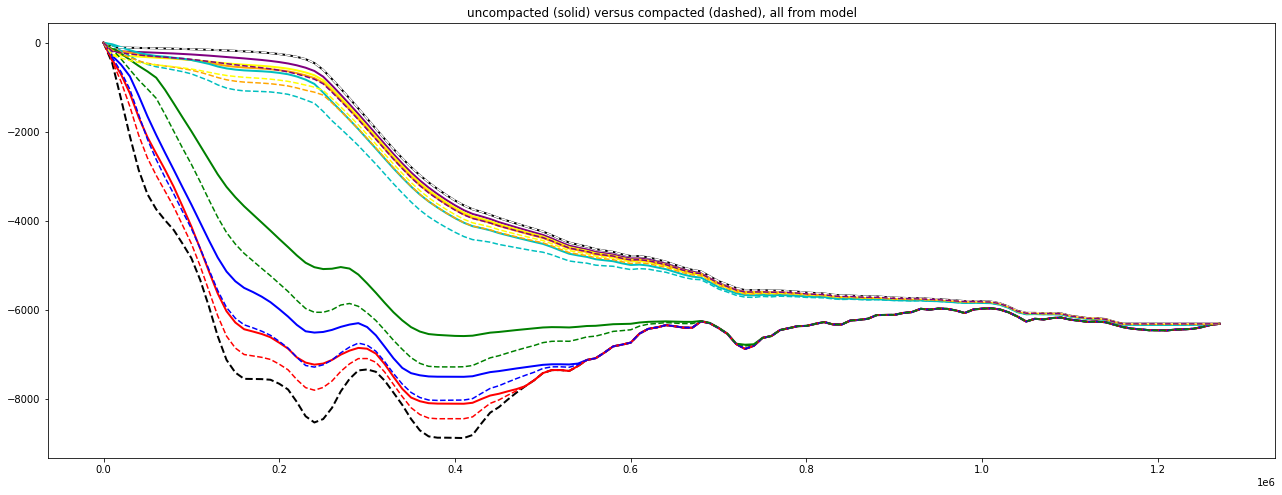

In [12]:
plt.figure(figsize=(22,8))

#now compare the two
plt.plot(out_ds.x, out_ds.profile__br[-2, :], linewidth = 2, color = 'k', linestyle='--')

plt.plot(out_ds.x, out_ds.profile__z[129999, :] + br_diff0000, linewidth = 2, color = 'k', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[119000, :] + br_diff000, linewidth = 2, color = 'purple', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[100000, :] + br_diff00, linewidth = 2, color = 'yellow', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[64000, :] + br_diff0, linewidth = 2, color = 'orange', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[49000, :] + br_diff1, linewidth = 2, color = 'c', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[36000, :] + br_diff2, linewidth = 2, color = 'g', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[30000, :] + br_diff3, linewidth = 2, color = 'b', linestyle='-')
plt.plot(out_ds.x, out_ds.profile__z[17000, :] + br_diff4, linewidth = 2, color = 'r', linestyle='-')

plt.plot(out_ds.x, out_ds.profile__z[129999, :], color = 'white', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[0, :], color = 'r', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[1, :], color = 'b', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[2, :], color = 'g', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[3, :], color = 'c', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[4, :], color = 'orange', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[5, :], color = 'yellow', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[6, :], color = 'purple', linestyle='--')

plt.title('uncompacted (solid) versus compacted (dashed), all from model')

Text(0.5, 1.0, 'dashed = model; solid = data')

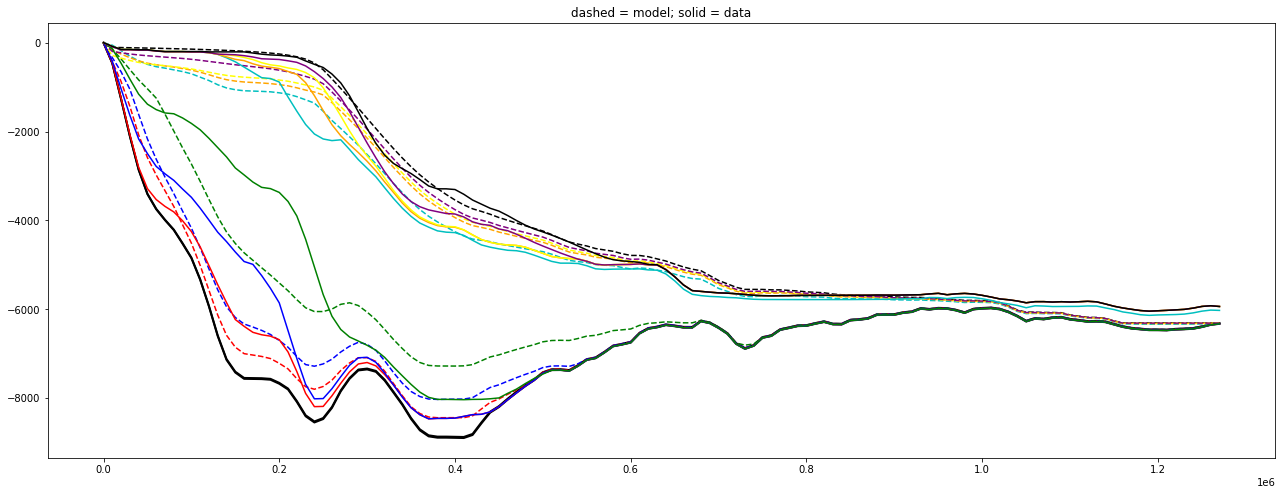

In [13]:
#now compare compacted layers against data
plt.figure(figsize=(22,8))

#bedrock
plt.plot(out_ds.x, out_ds.profile__br[-2, :], linewidth = 2, color = 'k', linestyle='-')

#compacted model
plt.plot(out_ds.x, out_ds.profile__z[129999, :], color='k', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[0, :], color='r', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[1, :], color='b', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[2, :], color='g', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[3, :], color='c', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[4, :], color='orange', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[5, :], color='yellow', linestyle='--')
plt.plot(out_ds.x, out_ds.profile__z[-2, :] - save_sed_thickness[6, :], color='purple', linestyle='--')

#data
plt.plot(out_ds.x, sed_surfaces[0, :], color = 'k', linewidth = 2)
plt.plot(out_ds.x, sed_surfaces[1, :], color = 'r')
plt.plot(out_ds.x, sed_surfaces[2, :], color = 'b')
plt.plot(out_ds.x, sed_surfaces[3, :], color = 'g')
plt.plot(out_ds.x, sed_surfaces[4, :], color = 'c')
plt.plot(out_ds.x, sed_surfaces[5, :], color = 'orange')
plt.plot(out_ds.x, sed_surfaces[6, :], color = 'yellow')
plt.plot(out_ds.x, sed_surfaces[7, :], color = 'purple')
plt.plot(out_ds.x, sed_surfaces[8, :], color = 'k')

plt.title('dashed = model; solid = data')

## integrate the data to get qs_in condition, then save that out for use in the model

In [7]:
phi = 0.56
z_star = 2830.
dx = 10000.
dt = 1000.
time_to_run = 130000000
qs_array_2 = np.zeros(int(time_to_run / dt))

#duration of each layer from bottom to top
layer_starts = [0, 17000000, 30000000, 36000000, 49000000, 64000000, 100000000, 119000000]
layer_durations = [17000000, 13000000, 6000000, 13000000, 15000000, 36000000, 19000000, 11000000]

for i in range(8): #for each layer
    layer_start = int(layer_starts[i] / dt)
    layer_duration = int(layer_durations[i] / dt)
    
    tot_depth_top = sed_surfaces[8, :]-sed_surfaces[i + 1, :]
    tot_depth_bottom = sed_surfaces[8, :]-sed_surfaces[i, :]
    
    integral_at_upper_depth = phi * z_star * np.exp(-tot_depth_top/z_star) + tot_depth_top
    integral_at_lower_depth = phi * z_star * np.exp(-tot_depth_bottom/z_star) + tot_depth_bottom

    def_int = - (integral_at_upper_depth - integral_at_lower_depth)
    
    #depth_top = sed_surfaces[8, :]-sed_surfaces[i + 1, :]
    #depth_bottom = sed_surfaces[8, :]-sed_surfaces[i, :]
    #depth_bottom[depth_bottom < depth_top] = depth_top[depth_bottom < depth_top]
    #definite_integral = phi * z_star * np.exp(-depth_bottom/z_star) * (np.exp((depth_top-depth_bottom)/z_star) - 1) - (depth_top-depth_bottom)
    
    total_sed = np.sum(def_int) * dx #now have m2
    qs_over_time_period = total_sed / layer_durations[i] #17 million years #now have m2/yr
    qs_array_2[layer_start:layer_start + layer_duration] = qs_over_time_period

In [25]:
#np.save('qs_array_correct.npy', qs_array_2)


[11.37407675 11.37407675 11.37407675 ...  7.05034095  7.05034095
  7.05034095]


(0.0, 130.0)

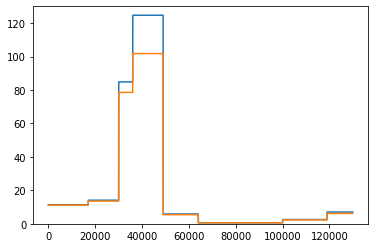

In [24]:

plt.plot(np.arange(len(qs_array)), qs_array)
plt.plot(np.arange(len(qs_array)), qs_array_2)

plt.ylim(0, 130)

In [53]:
np.sum(qs_array)*1000

2742435631.7934813

## now do the same for the model output

In [8]:
#try integration to get explicit qs for every MODELED layer
phi = 0.56
z_star = 2830.
dx = 10000.
dt = 1000.
time_to_run = 130000000
qs_array_model = np.zeros(int(time_to_run / dt))

#duration of each layer from bottom to top
layer_starts = [0, 17000000, 30000000, 36000000, 49000000, 64000000, 100000000, 119000000]
layer_durations = [17000000, 13000000, 6000000, 13000000, 15000000, 36000000, 19000000, 11000000]

sed_surfaces_model = np.zeros((9, n_nodes))
sed_surfaces_model[0, :] = np.array(out_ds.profile__br[-2, :]) #first line is bedrock
sed_surfaces_model[1, :] = out_ds.profile__z[-2, :] - save_sed_thickness[0, :]
sed_surfaces_model[2, :] = out_ds.profile__z[-2, :] - save_sed_thickness[1, :]
sed_surfaces_model[3, :] = out_ds.profile__z[-2, :] - save_sed_thickness[2, :]
sed_surfaces_model[4, :] = out_ds.profile__z[-2, :] - save_sed_thickness[3, :]
sed_surfaces_model[5, :] = out_ds.profile__z[-2, :] - save_sed_thickness[4, :]
sed_surfaces_model[6, :] = out_ds.profile__z[-2, :] - save_sed_thickness[5, :]
sed_surfaces_model[7, :] = out_ds.profile__z[-2, :] - save_sed_thickness[6, :]
sed_surfaces_model[8, :] = np.array(out_ds.profile__z[-2, :]) #last line is modern surface
modeled_integral = 0
for i in range(8): #for each layer
    layer_start = int(layer_starts[i] / dt)
    layer_duration = int(layer_durations[i] / dt)
    
    tot_depth_top = sed_surfaces_model[8, :]-sed_surfaces_model[i + 1, :]
    tot_depth_bottom = sed_surfaces_model[8, :]-sed_surfaces_model[i, :]
    
    integral_at_upper_depth = phi * z_star * np.exp(-tot_depth_top/z_star) + tot_depth_top
    integral_at_lower_depth = phi * z_star * np.exp(-tot_depth_bottom/z_star) + tot_depth_bottom

    def_int = - (integral_at_upper_depth - integral_at_lower_depth)
    
    #depth_top = sed_surfaces[8, :]-sed_surfaces[i + 1, :]
    #depth_bottom = sed_surfaces[8, :]-sed_surfaces[i, :]
    #depth_bottom[depth_bottom < depth_top] = depth_top[depth_bottom < depth_top]
    #definite_integral = phi * z_star * np.exp(-depth_bottom/z_star) * (np.exp((depth_top-depth_bottom)/z_star) - 1) - (depth_top-depth_bottom)
    
    total_sed = np.sum(def_int) * dx #now have m2
    qs_over_time_period = total_sed / layer_durations[i] #17 million years #now have m2/yr
    qs_array_model[layer_start:layer_start + layer_duration] = qs_over_time_period

3431106183.0088506
276227430602.31104
2743242816.9432235
3130436245.6099305


(0.0, 160.0)

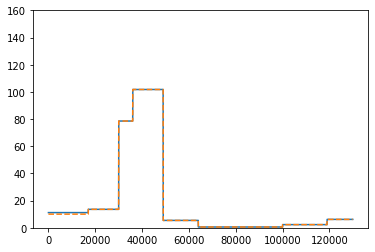

In [12]:
#compare sed flux time series from data against one from model
plt.plot(np.arange(len(qs_array_2)), qs_array_2)
plt.plot(np.arange(len(qs_array_2)), qs_array_model, linestyle='--')
#saved = np.load('qs_array.npy')
#plt.plot(np.arange(len(qs_array)), saved, linestyle='--')
plt.ylim(0, 160)

In [21]:
import scipy.stats as st
dist = st.uniform(-3, 4)
r = dist.rvs(size=1000)

(array([0.2504748 , 0.2504748 , 0.24797005, 0.23544631, 0.25548429,
        0.25798904, 0.2504748 , 0.22292257, 0.26550328, 0.26800803]),
 array([-2.99424419, -2.59500242, -2.19576065, -1.79651889, -1.39727712,
        -0.99803535, -0.59879358, -0.19955181,  0.19968995,  0.59893172,
         0.99817349]),
 <a list of 1 Patch objects>)

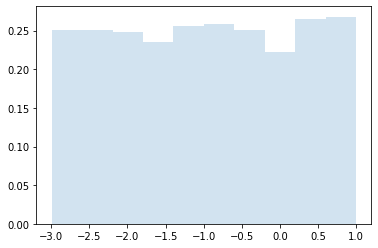

In [22]:
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)

Using swath profile:

Using K-S statistic on independent distributions:

Using K-S statistic on landscape index distribution: